# 手書き数字認識問題を解く
- 使用するデータはMNIST。
- シンプルなニューラルネットを使って、手書き数字認識をする。
    - [入力] 手書き数字の画像データ
    - [出力] 数字ラベル
- ニューラルネットには隠れ層を入れない。
    - 画像を__x__、ラベルを__y__とすれば、__x__→__y__

# データ読み込み&ニューラルネット用に変換
- 詳細は01_mnist.ipynbを参照

In [1]:
import numpy as np

f = np.load('mnist.npz')
x_train = f['x_train']
y_train = f['y_train']
x_test = f['x_test']
y_test = f['y_test']

# 28✖️28ピクセルの画像を784次元ベクトルに変換　＆　[0,1]に正規化
X_TRAIN = np.reshape(x_train, (60000, 784)) / 255.
X_TEST = np.reshape(x_test, (10000, 784)) / 255.

# one-hotベクトルに変換
Y_TRAIN = np.eye(10)[y_train]
Y_TEST = np.eye(10)[y_test]

# Kerasを使ってニューラルネットを組む

- Kerasでニューラルネットを組む場合、まずは入り口となる`Input`レイヤーを定義する。
- 下の例では`Input`レイヤーの次に全結合レイヤー（要するに普通のニューラルネット）`Dense`を繋げている。
- 分類問題の場合、出力の直前に`softmax`関数をかける。
- 入力は28✖️28の画像を一本の長いベクトルにしたものなので、28✖️28=784次元。
- `shape=784`とするとエラーが出る。
    - `shape`にはタプルというデータ形式を渡さなければならない。
    - スカラー量をタプルで表現する場合は、丸括弧とカンマを使って  
    `(スカラー,)`  
    とする。
- 0~9の計10個のクラスに分類するので、出力は10次元。

In [2]:
from keras.layers import Input, Dense

x = Input(shape=(784,))
y = Dense(10, activation='softmax')(x)

Using TensorFlow backend.


In [3]:
from keras.models import Model

neuralnet = Model(inputs=x, outputs=y)

- 構築したニューラルネットの詳細を表示する。
    - Layer (type): レイヤーの種類。
    - Output Shape: レイヤーを通り抜けた後のマトリクスのshape
    - Param #: パラメータの数

In [4]:
neuralnet.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                7850      
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________


- 損失関数と最適化手法を決める。
- 分類問題なら損失関数は`categorical_crossentropy`でOK。
- 最適化手法はとりあえず`adam`にしておけばたいていの場合問題ない。
- `metrics`のところに`acc`を指定すると、訓練中の分類精度の変遷が記録できる。
    - `metrics`はリスト形式で複数の値を渡すことができるようになっている。1つしか与えない場合でもリストにする（[　]で囲む）。

In [5]:
neuralnet.compile(
    loss='categorical_crossentropy', 
    optimizer='adam',
    metrics=['acc'],
)

# 訓練

- `fit`メソッドを使って訓練する。  
    x: 入力  
    y: 教師データ  
    epochs: 訓練回数  
    validation_split: 訓練データのうち、どの程度の割合をvalidationデータにするか
- validationデータはパラメータ更新には使わない。オーバーフィットの検知のために使う。

In [6]:
hist = neuralnet.fit(
    x = X_TRAIN,
    y = Y_TRAIN,
    epochs=30,
    validation_split=0.1,
)

Train on 54000 samples, validate on 6000 samples
Epoch 1/30
54000/54000 [==============================] - 2s - loss: 0.4878 - acc: 0.8726 - val_loss: 0.2718 - val_acc: 0.9248
Epoch 2/30
54000/54000 [==============================] - 2s - loss: 0.3136 - acc: 0.9128 - val_loss: 0.2474 - val_acc: 0.9303
Epoch 3/30
54000/54000 [==============================] - 2s - loss: 0.2916 - acc: 0.9192 - val_loss: 0.2352 - val_acc: 0.9357
Epoch 4/30
54000/54000 [==============================] - 2s - loss: 0.2802 - acc: 0.9213 - val_loss: 0.2292 - val_acc: 0.9377
Epoch 5/30
54000/54000 [==============================] - 2s - loss: 0.2735 - acc: 0.9232 - val_loss: 0.2261 - val_acc: 0.9392
Epoch 6/30
54000/54000 [==============================] - 2s - loss: 0.2685 - acc: 0.9251 - val_loss: 0.2258 - val_acc: 0.9387
Epoch 7/30
54000/54000 [==============================] - 2s - loss: 0.2642 - acc: 0.9259 - val_loss: 0.2222 - val_acc: 0.9383
Epoch 8/30
54000/54000 [==============================] - 2s -

# 訓練結果の確認

- ロスの変遷

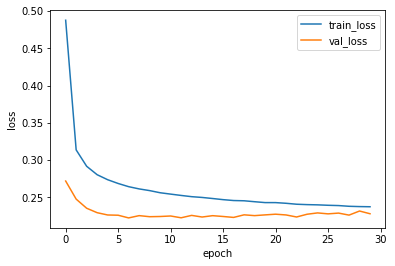

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(hist.epoch, hist.history['loss'], label='train_loss')
plt.plot(hist.epoch, hist.history['val_loss'], label='val_loss')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')

- 分類精度の変遷

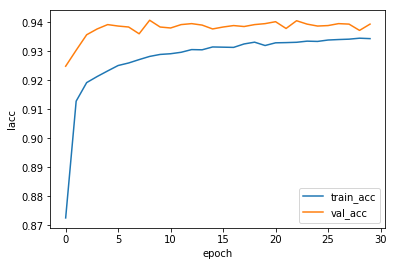

In [8]:
plt.plot(hist.epoch, hist.history['acc'], label='train_acc')
plt.plot(hist.epoch, hist.history['val_acc'], label='val_acc')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('lacc')

- 訓練後のニューラルネットにテストデータを入れて予測する。
- `Model`クラスの`evaluate`メソッドを使う。
    - 返り値は[損失, 分類精度]のリスト。

In [9]:
neuralnet.evaluate(x=X_TEST, y=Y_TEST)

 8736/10000 [=========================>....] - ETA: 0s

[0.2758333589017391, 0.92520000000000002]

- テストデータを訓練済みニューラルネットに入れた時の予測値を取り出す
- 10次元ベクトルになっているので、もっとも値の大きな次元だけを`argmax`を使って取り出す
    - `axis=1`を指定しないと、全データ＆全次元の中で最大の値を持っているインデックスが返ってきてしまう。

In [10]:
pred = neuralnet.predict(X_TEST).argmax(axis=1)
print(pred)

[7 2 1 ..., 4 5 6]


- 入力画像と予測ラベルを同時に表示して予測の正しさを確認する。

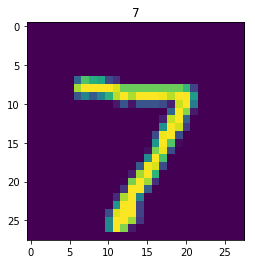

In [11]:
plt.imshow(x_test[0])
plt.title(str(pred[0]))